# Exercise 7 - Python: $k$-means Clustering and Principle Component Analysis

<img width="350px" src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif">

## *Part I*: $k$-means Clustering

**[Discuss section here]**

---

Beginning with package imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio  # Used to load the Octave/MATLAB *.mat files
from math import floor, ceil

%matplotlib inline

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

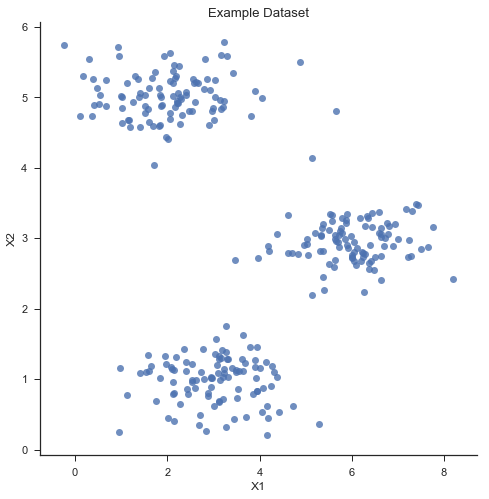

In [9]:
# Loading data and putting it into a data frame for plotting
X = sio.loadmat('ex7/ex7data2.mat')['X']
df = pd.DataFrame(X, columns=['X1', 'X2'])

# Visualizing data
sns.lmplot('X1', 'X2', data=df, fit_reg=False, size=7)
plt.title('Example Dataset');

### Implementing $k$-means

#### Finding Closest Centroids

This is the first step to $k$-means clustering before calculating and re-assigning centroids.  

For every example $i$, set:

$$c^{(i)} := j\ \text{that minimizes}\ \|x^{(i)} - \mu_j \|^2
\\
c^{(i)}: \text{Index of the centroid that is closest to}\ x^{(i)}\ 
\\
\mu_j: \text{Position (value) of the}\ j\text{'th centroid}$$

#### Computing Centroid 

This is the second step to $k$-means clustering that is used to re-assign centroids.

For every centroid $k$, set:

$$\mu_k := \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}
\\
C_k: \text{Set of examples that are assigned to centroid }k$$

### $k$-means on example dataset

### Random Initialization

We were provided with initial centroids for the previous parts of the exercise, but it's prudent to use random starting points to avoid falling into a local minima.

### Image Compression with $k$-means

---

##  *Part II:* Principal Component Analysis

**[Discuss section here]**

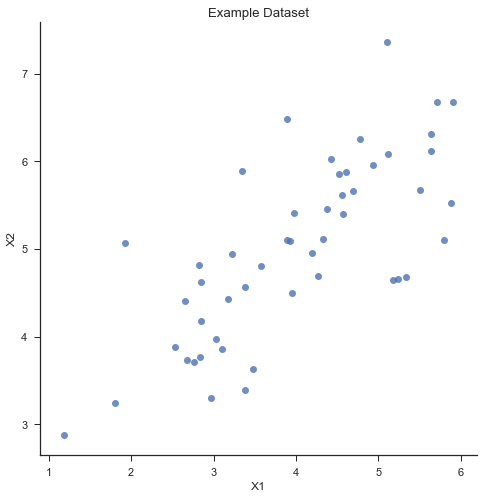

In [3]:
# Loading data and putting it into a data frame for plotting
X = sio.loadmat('ex7/ex7data1.mat')['X']
df = pd.DataFrame(X, columns=['X1', 'X2'])

# Visualizing data
sns.lmplot('X1', 'X2', data=df, fit_reg=False, size=7)
plt.title('Example Dataset');

### Implementing PCA

### Dimensionality Reduction with PCA

#### Projecting Data onto Principal Components

#### Reconstructing an Approximation of the Data

#### Visualizing the Projections

### Face Image Dataset

In [4]:
X = sio.loadmat('ex7/ex7faces.mat')['X']

X.shape

(5000, 1024)

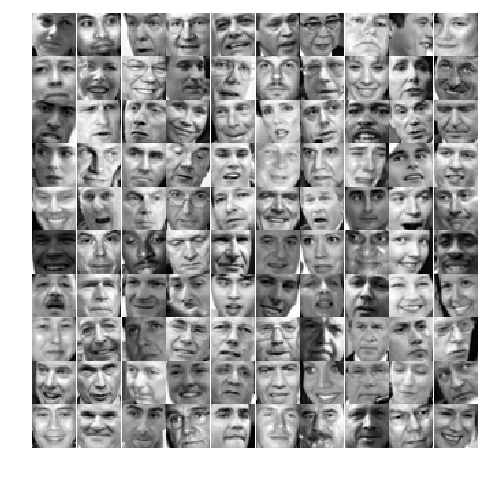

In [6]:
# Randomly sampling 100 faces to display
random100 = X[np.random.randint(X.shape[0], size=100), :]


def plot_faces(faces, width=8, height=8):
    """Plots a grid of the supplied faces"""
    # Creating the overall figure to fill with plots of the numbers
    fig = plt.figure(figsize=(width, height))

    # Calculates the number of columns/rows for the subplot grid
    figShape = np.sqrt(faces.shape[0])

    # Loop over numbers to plot into the overall figure
    for i, face in enumerate(faces):  # Enumerating to include index
        face = face.reshape(32, 32).T  # Reshape X into 32x32 array
        ax = fig.add_subplot(floor(figShape),  # Rows
                             ceil(figShape),  # Columns
                             i + 1)  # Positioning
        plt.imshow(face, cmap='gray')  # Plotting the face

        # Removing unnecessary components for aesthetics
        plt.grid(False)
        plt.axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()


plot_faces(faces=random100)

#### PCA on Faces

#### Dimensionality Reduction